In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
import pathlib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve
import seaborn as sns
import datetime

In [2]:
model_name = "model 2"

In [3]:
data_dir = 'dataset rembg'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.png')))
image_count

130

In [4]:
raw_durian_images_dict = {
    'ripe' : list(data_dir.glob('ripe/*')),
    'unripe' : list(data_dir.glob('unripe/*')),
} 
raw_durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}

In [5]:
X, y = [], []
image_input_shape = 200
output_folder = "resized_images"

for durian_ripeness, images in raw_durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(image_input_shape,image_input_shape))
        X.append(resized_img)
        y.append(raw_durian_labels_dict[durian_ripeness])

In [6]:
X = np.array(X)
y = np.array(y)

In [7]:
# Initial split to get training + validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

# Secondary split to get training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=42, stratify=y_train_val)

# Normalize / Rescale the pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [8]:
# LeNet-5
convDim = 5
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(6, (convDim,convDim), activation='relu', input_shape=(200,200,3)),
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.Conv2D(16, (convDim,convDim), activation='relu'),
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.Conv2D(120, (convDim,convDim), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(84, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file="current_cnn.png")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 196, 6)       456       
                                                                 
 average_pooling2d (Average  (None, 98, 98, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 94, 16)        2416      
                                                                 
 average_pooling2d_1 (Avera  (None, 47, 47, 16)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_2 (Conv2D)           (None, 43, 43, 120)       48120     
                                                                 
 flatten (Flatten)           (None, 221880)            0

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when the loss falls below 0.4

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the loss
    if(logs.get('val_accuracy') > 0.9):

      # Stop if threshold is met
      print("\Accuracy is reached than 0.9 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [10]:
EPOCH = 100
BATCH_SIZE = 32
model_fit = model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val, y_val), batch_size=BATCH_SIZE) 

Epoch 1/100
2/2 [==============================] - 4s 2s/step - loss: 1.0694 - accuracy: 0.4423 - val_loss: 1.0512 - val_accuracy: 0.5385
Epoch 2/100
2/2 [==============================] - 3s 2s/step - loss: 0.9439 - accuracy: 0.5385 - val_loss: 0.6561 - val_accuracy: 0.5577
Epoch 3/100
2/2 [==============================] - 2s 974ms/step - loss: 0.6515 - accuracy: 0.6538 - val_loss: 0.6531 - val_accuracy: 0.7885
Epoch 4/100
2/2 [==============================] - 2s 947ms/step - loss: 0.6054 - accuracy: 0.9038 - val_loss: 0.6343 - val_accuracy: 0.5577
Epoch 5/100
2/2 [==============================] - 2s 934ms/step - loss: 0.5335 - accuracy: 0.7308 - val_loss: 0.5739 - val_accuracy: 0.7308
Epoch 6/100
2/2 [==============================] - 2s 900ms/step - loss: 0.4307 - accuracy: 0.8846 - val_loss: 0.5155 - val_accuracy: 0.7885
Epoch 7/100
2/2 [==============================] - 2s 880ms/step - loss: 0.3144 - accuracy: 0.9231 - val_loss: 0.4939 - val_accuracy: 0.8077
Epoch 8/100
2/2 [==

In [11]:
test_loss , test_accuracy = model.evaluate(X_test,y_test)
print(f'Model Accuracy: {test_accuracy*100}%')

1/1 [==============================] - 0s 112ms/step - loss: 2.1534 - accuracy: 0.7308
Model Accuracy: 73.07692170143127%


In [12]:
predictions = model.predict(X_test)
predictions = np.round(predictions,2)
predictions.flatten()

1/1 [==============================] - 0s 209ms/step


array([0.01, 0.47, 0.  , 0.  , 1.  , 0.  , 0.02, 0.  , 0.  , 1.  , 0.04,
       0.1 , 0.03, 0.  , 0.  , 1.  , 0.  , 0.94, 0.84, 0.  , 0.  , 0.02,
       0.01, 0.  , 0.01, 0.  ], dtype=float32)

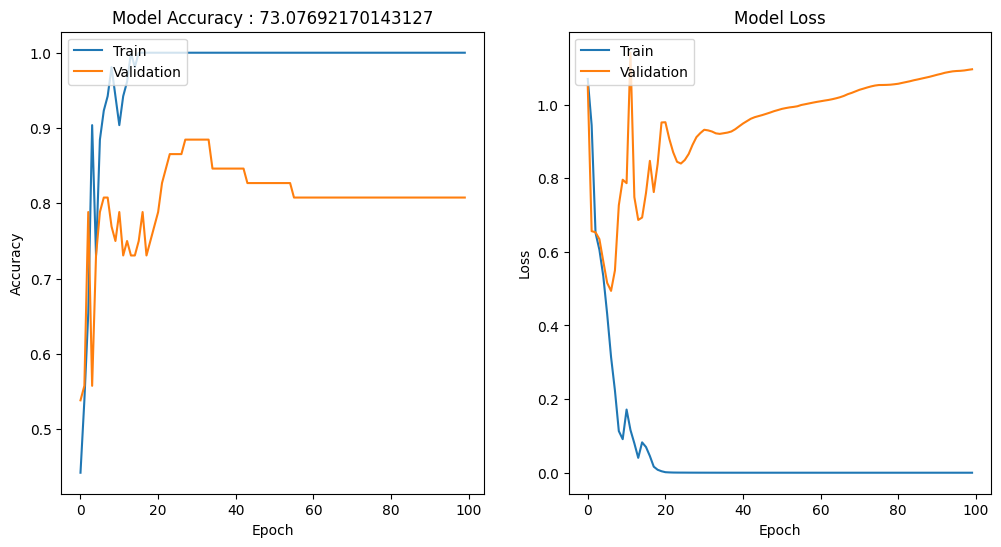

In [13]:
# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])  # Add validation accuracy
plt.title(f'Model Accuracy : {test_accuracy*100}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Get current date and time
now = datetime.datetime.now()

# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M%S")

# Save the plot with the specified name format
plt.savefig(f"hasil training/{model_name}.png")
plt.show()

In [14]:
# save model to .keras file
now = datetime.datetime.now()
# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%d%m%Y-%H%M%S")

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open(f'model/{model_name}.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\fzrah\AppData\Local\Temp\tmp6uruj7hp\assets


INFO:tensorflow:Assets written to: C:\Users\fzrah\AppData\Local\Temp\tmp6uruj7hp\assets


ROC and AUC to determine the most optimal threshold for Confussion Matrix \
Credit : https://www.youtube.com/watch?v=Joh3LOaG8Q0 (Dr. Sreenivas Bhattiprolu)

1/1 [==============================] - 0s 111ms/step


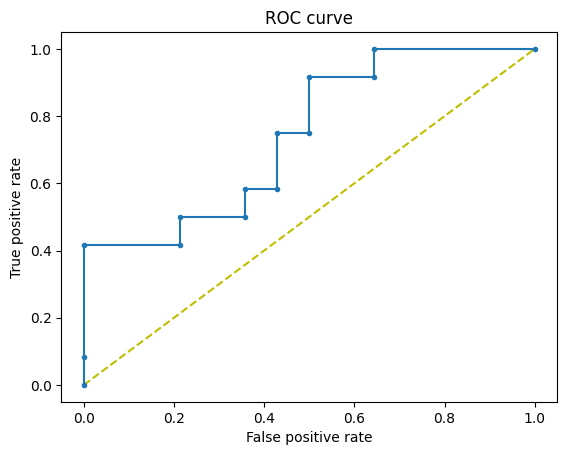

In [16]:
# Make predictions
y_preds = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [17]:
i = np.arange(len(tpr)) 
roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'thresholds' : pd.Series(thresholds, index=i)})
ideal_roc_thresh = roc.iloc[(roc.tf-0).abs().argsort()[:1]]  #Locate the point where the value is close to 0
print("Ideal threshold is: ", ideal_roc_thresh['thresholds']) 

Ideal threshold is:  7    0.008361
Name: thresholds, dtype: float32


1/1 [==============================] - 0s 105ms/step


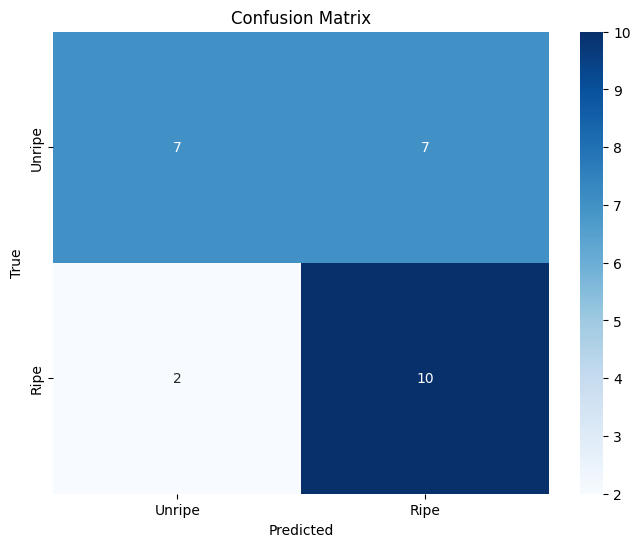

In [18]:
# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.000019).astype(int)  # Assuming it's a binary classification problem

# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()